In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nivapy3 as nivapy
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings

#warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [2]:
# Connect to NIVABASE
eng = nivapy.da.connect()

Username:  ···
Password:  ········


Connection successful.


# ICPW Thematic Report 2020 - Nitrogen (Part 2: Annual trends)

Calculating annual trends for the nitrogen report. See the issue [here](https://github.com/JamesSample/icpw2/issues/1) for details.

## 1. Get stations

In [3]:
# Read stations
stn_path = r'../data/all_icpw_sites_may_2019.xlsx'
stn_df = pd.read_excel(stn_path, sheet_name='all_icpw_stns')

# Check stn numbers seem OK
trend_df = stn_df.query("group in ('Trends', 'Trends+Core')")
core_df = stn_df.query("group in ('Core', 'Trends+Core')")

print(f'There are {len(stn_df)} unique stations within the ICPW project as a whole.')
stn_df.head()

There are 556 unique stations within the ICPW project as a whole.


,station_id,station_code,station_name,latitude,longitude,altitude,continent,country,region,group
0,38115,Tr18_CA_DO1,Blue Chalk Lake,45.1999,-78.9432,344.0,North America,Canada,Ont,Trends
1,38116,Tr18_CA_DO2,Chub Lake,45.2138,-78.9836,343.0,North America,Canada,Ont,Trends
2,38117,Tr18_CA_DO3,Crosson Lake,45.0840,-79.0360,371.0,North America,Canada,Ont,Trends
3,38118,Tr18_CA_DO4,Dickie Lake,45.1510,-79.0876,379.0,North America,Canada,Ont,Trends
4,38119,Tr18_CA_DO5,Harp Lake,45.3798,-79.1335,327.0,North America,Canada,Ont,Trends


## 2. Extract raw chemistry data

In [4]:
# Specify time period of interest
st_dt = '1990-01-01'
end_dt = '2016-12-31'

# Get available parameters
par_df = nivapy.da.select_resa_station_parameters(stn_df, st_dt, end_dt, eng)
par_df

35 parameters available for the selected stations and dates.


,parameter_id,parameter_name,unit
0,65,ALK-E,µEq/l
1,50,Al,µg/l
2,223,As,µg/l
3,959,COLOUR,None
4,11,Ca,mg/l
5,15,Cd,µg/l
6,7,Cl,mg/l
7,225,Cr,µg/l
8,16,Cu,µg/l
9,879,DOC,mg/L C


In [5]:
# Get data
wc_df, dup_df = nivapy.da.select_resa_water_chemistry(stn_df,
                                                      [4, 5, 6, 24, 49], # [TotN, NO3, TOC, TotP, NH4]
                                                      st_dt,
                                                      end_dt,
                                                      eng,
                                                      lod_flags=False,
                                                      drop_dups=True)
wc_df.head()

WARNING
The database contains unexpected duplicate values for some station-date-parameter combinations.
Only the most recent values will be used, but you should check the repeated values are not errors.
The duplicated entries are returned in a separate dataframe.



,station_id,station_code,station_name,sample_date,depth1,depth2,NH4-N_µg/l N,NO3-N_µg/l N,TOC_mg C/l,TOTN_µg/l N,TOTP_µg/l P
,,,,,,,,,,,
0,23472,CH03,Lago di Tomè,1990-10-08,0.0,0.0,20.0,330.0,NaN,NaN,NaN
1,23472,CH03,Lago di Tomè,1993-08-18,0.0,0.0,30.0,490.0,NaN,NaN,NaN
2,23472,CH03,Lago di Tomè,1995-09-05,0.0,0.0,0.0,510.0,NaN,NaN,NaN
3,23472,CH03,Lago di Tomè,1995-09-15,0.0,0.0,0.0,450.0,NaN,NaN,NaN
4,23472,CH03,Lago di Tomè,1997-08-05,0.0,0.0,10.0,330.0,NaN,NaN,NaN


In [6]:
# Only consider samples within 1 m of surface
wc_df = wc_df.query('depth2 < 1')

## 3. Calculate derived parameters

In [7]:
# TON
wc_df['TON_µg/l N'] = wc_df['TOTN_µg/l N'] - wc_df['NO3-N_µg/l N'] - wc_df['NH4-N_µg/l N']

# TOTN/TOTP
wc_df['TOTN/TOTP'] = wc_df['TOTN_µg/l N'] / wc_df['TOTP_µg/l P']

# NO3/TOTP
wc_df['NO3/TOTP'] = wc_df['NO3-N_µg/l N'] / wc_df['TOTP_µg/l P']

# TOC/TON
wc_df['TOC/TON'] = 1000 * wc_df['TOC_mg C/l'] / wc_df['TON_µg/l N']

# TOC/TOTP
wc_df['TOC/TOTP'] = 1000 * wc_df['TOC_mg C/l'] / wc_df['TOTP_µg/l P']

In [8]:
# Save for speed
csv_path = r'../../../Thematic_Trends_Report_2020/data_matrices/thematic_n_report_2020_working_data.csv'
wc_df.to_csv(csv_path, index=False, encoding='utf-8')

In [9]:
# Read saved data
wc_df = pd.read_csv(csv_path, encoding='utf-8')
wc_df['sample_date'] = pd.to_datetime(wc_df['sample_date'], format='%Y-%m-%d')
wc_df.head()

,station_id,station_code,station_name,sample_date,depth1,depth2,NH4-N_µg/l N,NO3-N_µg/l N,TOC_mg C/l,TOTN_µg/l N,TOTP_µg/l P,TON_µg/l N,TOTN/TOTP,NO3/TOTP,TOC/TON,TOC/TOTP
0,23472,CH03,Lago di Tomè,1990-10-08,0.0,0.0,20.0,330.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23472,CH03,Lago di Tomè,1993-08-18,0.0,0.0,30.0,490.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23472,CH03,Lago di Tomè,1995-09-05,0.0,0.0,0.0,510.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23472,CH03,Lago di Tomè,1995-09-15,0.0,0.0,0.0,450.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23472,CH03,Lago di Tomè,1997-08-05,0.0,0.0,10.0,330.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Aggregate to annual medians

In [10]:
# Annual medians by station
wc_df['year'] = wc_df['sample_date'].dt.year
ann_df = wc_df.groupby(['station_id', 'year']).median().reset_index()

ann_df.head()

,station_id,year,depth1,depth2,NH4-N_µg/l N,NO3-N_µg/l N,TOC_mg C/l,TOTN_µg/l N,TOTP_µg/l P,TON_µg/l N,TOTN/TOTP,NO3/TOTP,TOC/TON,TOC/TOTP
0,23472,1990,0.0,0.0,20.0,330.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23472,1993,0.0,0.0,30.0,490.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23472,1995,0.0,0.0,0.0,480.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23472,1997,0.0,0.0,10.0,350.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23472,2000,0.0,0.0,23.0,506.262169,NaN,764.731,NaN,235.468831,NaN,NaN,NaN,NaN


## 5. Explore selection criteria

In [11]:
# Melt to long format
df = ann_df.copy()
del df['depth1'], df['depth2']
df = pd.melt(df, id_vars=['station_id', 'year'])
df.dropna(how='any', inplace=True)
df.head()

,station_id,year,variable,value
0,23472,1990,NH4-N_µg/l N,20.0
1,23472,1993,NH4-N_µg/l N,30.0
2,23472,1995,NH4-N_µg/l N,0.0
3,23472,1997,NH4-N_µg/l N,10.0
4,23472,2000,NH4-N_µg/l N,23.0


In [12]:
# Define selection criteria
n_start_thresh = 1         # Number of annual values in first 5 years
n_end_thresh = 1           # Number of annual values in last 5 years
prop_thresh = 0.65         # Proportion of total years with data

# Dict for results
inc_dict = {'station_id':[],
            'variable':[],
            'st_yr':[],
            'include':[],
           }

# Loop over time series
for stn_id in df['station_id'].unique():       
    # Loop over variables
    for par in df['variable'].unique():
        # Get data
        stn_par_df = df.query("(station_id == @stn_id) and (variable == @par)")
        stn_par_df.set_index('year', inplace=True)
        del stn_par_df['station_id'], stn_par_df['variable']
        
        for st_yr in range(1990, 2006):           

            # Years from st_yr to 2016
            years = range(st_yr, 2017)
            n_yrs = 2017 - st_yr
            yrs_thresh = round(n_yrs * prop_thresh)
            years_df = pd.DataFrame(index=years)

            # Resample to annual
            stn_par_yr_df = years_df.join(stn_par_df)
            
            if pd.isna(stn_par_yr_df['value']).all().all():
                # Not suitable
                inc_dict['station_id'].append(stn_id)
                inc_dict['variable'].append(par)
                inc_dict['st_yr'].append(st_yr)
                inc_dict['include'].append(0) 

            else:
                n_start = pd.notnull(stn_par_yr_df[stn_par_yr_df.index<(st_yr + 5)]['value']).sum()
                n_end = pd.notnull(stn_par_yr_df[stn_par_yr_df.index>(2011)]['value']).sum()
                non_missing = pd.notnull(stn_par_yr_df['value']).sum()

                if (n_start >= n_start_thresh) and (n_end >= n_end_thresh) and (non_missing >= yrs_thresh):
                    # Include
                    inc_dict['station_id'].append(stn_id)
                    inc_dict['variable'].append(par)
                    inc_dict['st_yr'].append(st_yr)
                    inc_dict['include'].append(1) 

                else:
                    # Not suitable
                    inc_dict['station_id'].append(stn_id)
                    inc_dict['variable'].append(par)
                    inc_dict['st_yr'].append(st_yr)
                    inc_dict['include'].append(0)   

# Build df
inc_df = pd.DataFrame(inc_dict)

# Calculate bool cols describing presence of *combinations* of params
# Unstack to 'wide'
inc_df.set_index(['station_id', 'variable', 'st_yr'], inplace=True)
inc_df = inc_df.unstack('variable')
inc_df.columns = inc_df.columns.get_level_values(1)
inc_df.reset_index(inplace=True)

# Are all params present?
inc_df['TOC_TOTN_NO3'] = ((inc_df['TOC_mg C/l'] + 
                           inc_df['TOTN_µg/l N'] + 
                           inc_df['NO3-N_µg/l N']) == 3).astype(int)

inc_df['TOC_TOTN_NO3_NH4'] = ((inc_df['TOC_mg C/l'] + 
                               inc_df['TOTN_µg/l N'] + 
                               inc_df['NO3-N_µg/l N'] + 
                               inc_df['NH4-N_µg/l N']) == 4).astype(int)

# Melt back to 'long'
inc_df = inc_df.melt(id_vars=['station_id', 'st_yr'],
                     value_name='n_stns',
                    )

# Sum number of stations
nstns_df = inc_df.groupby(['variable', 'st_yr']).sum().reset_index()
del nstns_df['station_id']

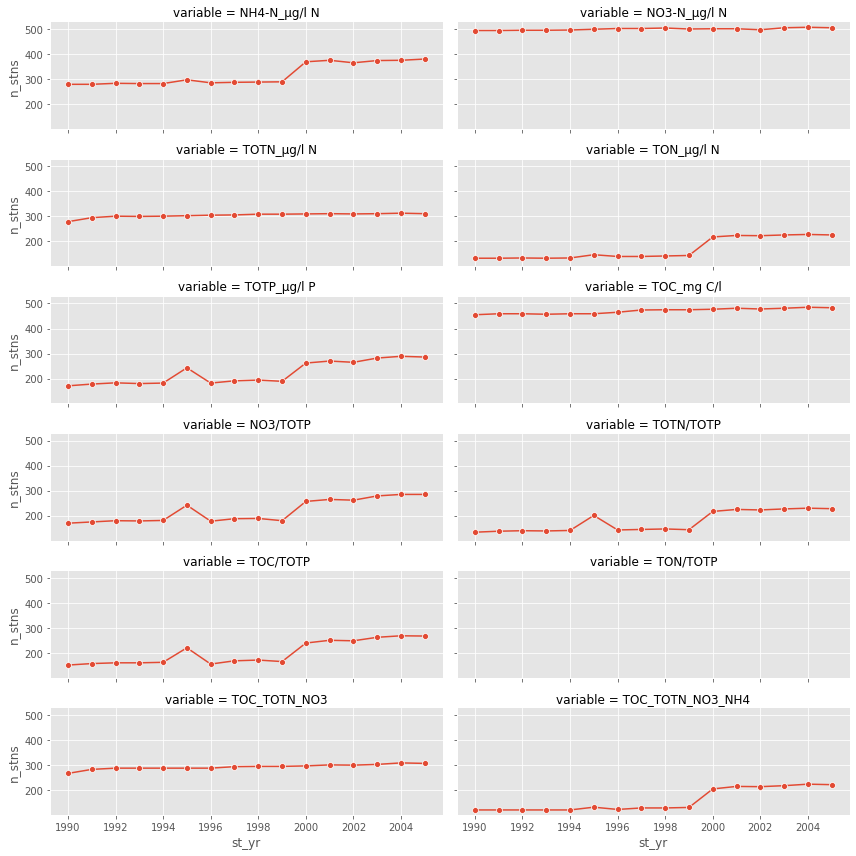

In [13]:
# Plot
sn.relplot(data=nstns_df, 
           x='st_yr',
           y='n_stns',
           col='variable',
           col_wrap=2,
           aspect=3,
           height=2,
           kind='line',
           marker='o',
           col_order=['NH4-N_µg/l N',
                      'NO3-N_µg/l N',
                      'TOTN_µg/l N',
                      'TON_µg/l N',
                      'TOTP_µg/l P',
                      'TOC_mg C/l',
                      'NO3/TOTP',
                      'TOTN/TOTP',
                      'TOC/TOTP',
                      'TON/TOTP',
                      'TOC_TOTN_NO3',
                      'TOC_TOTN_NO3_NH4'
                      ],
          )

plt.savefig('nstns_selected_by_styr.png', dpi=200)